In [8]:
%%capture
!git clone https://github.com/apple/ml-depth-pro.git
%cd ml-depth-pro
!pip install -e .

In [9]:
%%capture
!pip install huggingface-hub
!huggingface-cli download --local-dir checkpoints apple/DepthPro
%cd ..

In [10]:
!pip install numpy==1.26.4

In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('ml-depth-pro/src')
!ln -s ml-depth-pro/checkpoints ./checkpoints # create a symbolic link to manage relative paths

os.makedirs("input_images",   exist_ok=True)
os.makedirs("raw_depth_output", exist_ok = True)
os.makedirs("depth_blur_results", exist_ok = True)

import warnings
warnings.filterwarnings('ignore')

ln: failed to create symbolic link './checkpoints/checkpoints': File exists


In [2]:
np.__version__

'1.26.4'

In [3]:
import depth_pro
import torch

model, transform = depth_pro.create_model_and_transforms(precision=torch.half)
model.to("cuda").eval()
print("Model Loaded Successfully...")


Model Loaded Successfully...


In [9]:
# Predict raw depth using Depth Pro
def predict_depth(rgb_image, output_path):

    # Load and preprocess an image.
    image, _, f_px = depth_pro.load_rgb(image_path)
    image = transform(image).to("cuda")

    # Run inference.
    prediction = model.infer(image, f_px=f_px)
    depth = prediction["depth"]  # Depth in [m].
    focallength_px = prediction["focallength_px"]  # Focal length in pixels.
    inverse_depth = 1 / depth

    # ************* Clipping and Normalization *************
    # Normalize the depth map to [0, 255]
    depth = (depth - depth.min()) / depth.max()  # Normalize to [0, 1]
    depth = depth * 255.  # Scale to [0, 255]

    # ******************************************************
    # Visualize inverse depth instead of depth, clipped to [0.1m;250m] range for better visualization.
    max_invdepth_vizu = min(inverse_depth.max(), 1 / 0.1)
    min_invdepth_vizu = max(1 / 250, inverse_depth.min())
    inverse_depth_normalized = (inverse_depth - min_invdepth_vizu) / (
        max_invdepth_vizu - min_invdepth_vizu)

    inverse_depth = inverse_depth_normalized * 255. # Scale to [0, 255]
    inverse_depth = inverse_depth.cpu().numpy()

    # ********************************************************
    # Convert depth map to a NumPy array
    depth = depth.detach().cpu().numpy().astype("uint8")


    # Save the resized depth map
    cv2.imwrite(output_path, depth)

    return depth, inverse_depth

In [10]:
def plot(rgb_image, raw_depth, inverse_depth):

    # Create subplots (1 row, 5 columns)
    fig, ax = plt.subplots(5, 1, figsize=(10, 25))

    # Image Titles
    titles = ["RGB Image", "Raw Depth Map", "Colored Depth Map", "Inverse Depth Map", "Colored Inverse Depth Map"]
    images = [rgb_image, raw_depth, raw_depth, inverse_depth, inverse_depth]
    cmaps = [None, "gray", "inferno", "gray", "inferno"]  # Colormap settings

    for i in range(5):
        ax[i].imshow(images[i], cmap = cmaps[i])
        ax[i].axis('off')
        ax[i].set_title(titles[i])
        ax[i].set_anchor('C')

    plt.tight_layout()
    plt.show()

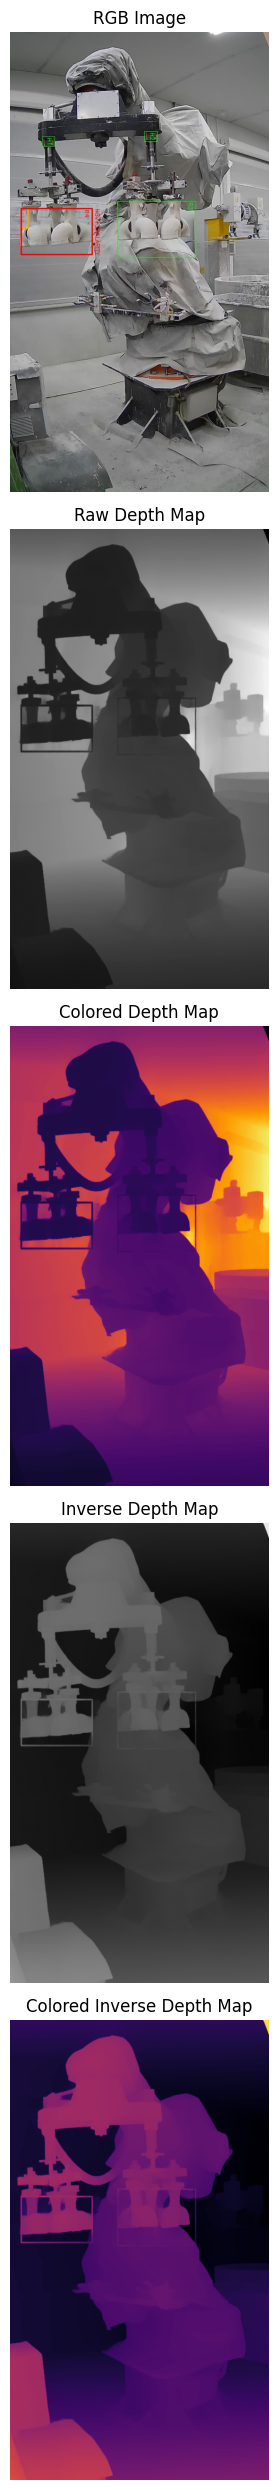

In [11]:

image_path = "/content/20251211_062255_235_result_CAM1.jpg"
image_fname = os.path.splitext(os.path.basename(image_path))[0]
output_path = f"raw_depth_output/{image_fname}_raw_depth.png"

# Load RGB image and depth map
rgb_image = cv2.imread(image_path)[:, :, ::-1]  # Convert BGR to RGB
raw_depth = cv2.imread(output_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale depth map

raw_depth, inverse_depth = predict_depth(rgb_image, output_path)

plot(rgb_image, raw_depth, inverse_depth)

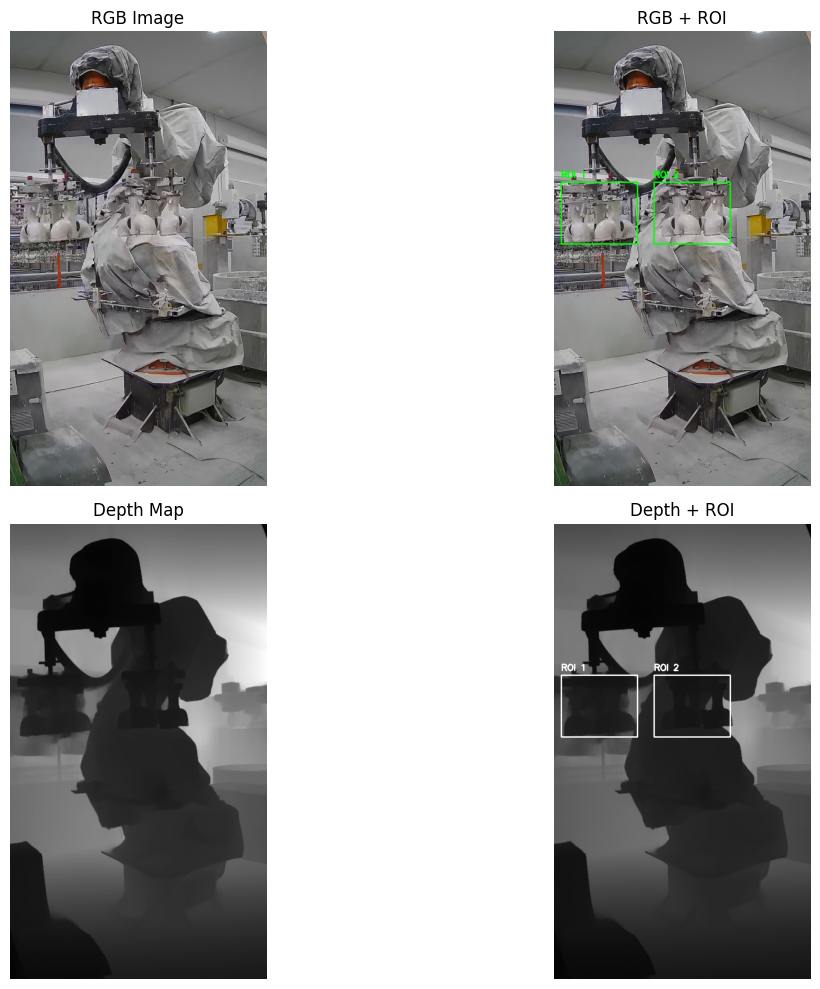

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ================== ROI CONFIG ==================
ROI_W = 160   # chiều rộng ROI
ROI_H = 130   # chiều cao ROI

ROI_POINTS = [
    (15, 320),  # ROI 1 (x, y)
    (210, 320),  # ROI 2 (x, y)
]

# ================== PATH ==================
image_path = "/content/20251211_062255_235_front_CAM1.jpg"
image_fname = os.path.splitext(os.path.basename(image_path))[0]
output_path = f"raw_depth_output/{image_fname}_raw_depth.png"

# ================== LOAD IMAGE ==================
bgr = cv2.imread(image_path)
if bgr is None:
    raise RuntimeError("Không đọc được ảnh")

rgb_image = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

# ================== DEPTH PREDICT ==================
raw_depth, inverse_depth = predict_depth(image_path, output_path)

# ================== VẼ ROI ==================
def draw_rois(img, rois, w, h, color=(0, 255, 0)):
    img_draw = img.copy()
    for i, (x, y) in enumerate(rois, 1):
        cv2.rectangle(
            img_draw,
            (x, y),
            (x + w, y + h),
            color,
            2
        )
        cv2.putText(
            img_draw,
            f"ROI {i}",
            (x, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            color,
            2
        )
    return img_draw

rgb_with_roi = draw_rois(rgb_image, ROI_POINTS, ROI_W, ROI_H)
depth_with_roi = draw_rois(raw_depth, ROI_POINTS, ROI_W, ROI_H, color=(255, 255, 255))

# ================== PLOT ==================
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

ax[0, 0].imshow(rgb_image)
ax[0, 0].set_title("RGB Image")
ax[0, 0].axis("off")

ax[0, 1].imshow(rgb_with_roi)
ax[0, 1].set_title("RGB + ROI")
ax[0, 1].axis("off")

ax[1, 0].imshow(raw_depth, cmap="gray")
ax[1, 0].set_title("Depth Map")
ax[1, 0].axis("off")

ax[1, 1].imshow(depth_with_roi, cmap="gray")
ax[1, 1].set_title("Depth + ROI")
ax[1, 1].axis("off")

plt.tight_layout()
plt.show()



📐 ROI 1 – Grid depth (7 x 8):
[[ 36.68    16.5875  26.95    16.5325  14.4175  19.415   34.1575  25.3375]
 [ 82.1775  48.2025  75.705   63.89    57.3575  65.24   110.3     99.48  ]
 [ 86.8825  57.105   85.8225  78.485   54.6025  42.15    88.1975  91.86  ]
 [ 89.0675  99.99   102.8625 101.925  103.925   96.74   114.015   98.35  ]
 [ 85.6825  97.435  100.1925 100.265  103.8025 110.9775 115.3825  98.8075]
 [ 80.3075  88.1425 105.5775 107.64   110.0475 113.06   115.76    94.3175]
 [ 81.005   91.6525 108.27   109.515  110.195  112.4875 115.1075  82.48  ]]

📐 ROI 2 – Grid depth (7 x 8):
[[ 34.79    33.9075  31.1975  27.62    26.125   30.945   29.9425  36.7   ]
 [ 36.61    35.765   35.395   37.9725  37.86    39.59    41.3875  42.54  ]
 [ 37.095   38.015   40.245   41.9475  41.6075  55.5875 138.4475 112.04  ]
 [ 39.5     39.095   39.405   40.2525  41.385  100.11   151.1775 159.7475]
 [ 40.8775  40.27    39.0125  39.52    41.035  119.0075 151.57   159.355 ]
 [ 39.7975  37.7625  36.9275  37.0625

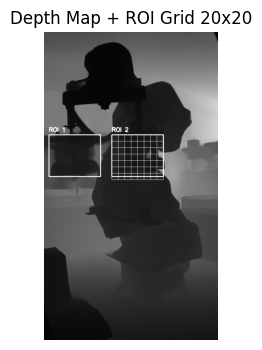

In [15]:
# ================== GRID CONFIG ==================
CELL_SIZE = 20

# ================== TÍNH DEPTH THEO Ô ==================
def compute_grid_depth(depth_map, roi_x, roi_y, roi_w, roi_h, cell_size=20):
    rows = roi_h // cell_size
    cols = roi_w // cell_size

    grid_depth = np.zeros((rows, cols), dtype=np.float32)

    for r in range(rows):
        for c in range(cols):
            x0 = roi_x + c * cell_size
            y0 = roi_y + r * cell_size
            x1 = x0 + cell_size
            y1 = y0 + cell_size

            cell = depth_map[y0:y1, x0:x1]
            grid_depth[r, c] = np.mean(cell)

    return grid_depth

# ================== VẼ LƯỚI 20x20 ==================
def draw_grid(img, roi_x, roi_y, roi_w, roi_h, cell_size=20, color=(255, 0, 0)):
    img_draw = img.copy()

    # vẽ đường dọc
    for x in range(roi_x, roi_x + roi_w + 1, cell_size):
        cv2.line(img_draw, (x, roi_y), (x, roi_y + roi_h), color, 1)

    # vẽ đường ngang
    for y in range(roi_y, roi_y + roi_h + 1, cell_size):
        cv2.line(img_draw, (roi_x, y), (roi_x + roi_w, y), color, 1)

    return img_draw

# ================== ÁP DỤNG CHO 2 ROI ==================
for idx, (rx, ry) in enumerate(ROI_POINTS, start=1):
    grid = compute_grid_depth(
        raw_depth,
        rx, ry,
        ROI_W, ROI_H,
        CELL_SIZE
    )

    print(f"\n📐 ROI {idx} – Grid depth ({grid.shape[0]} x {grid.shape[1]}):")
    print(grid)

    # vẽ lưới lên ảnh depth
    depth_with_grid = draw_grid(
        depth_with_roi,
        rx, ry,
        ROI_W, ROI_H,
        CELL_SIZE
    )

# ================== HIỂN THỊ ==================
plt.figure(figsize=(6, 4))
plt.imshow(depth_with_grid, cmap="gray")
plt.title("Depth Map + ROI Grid 20x20")
plt.axis("off")
plt.show()



Processing: /content/20251211_024107_433_front_CAM1.jpg

📐 20251211_024107_433_front_CAM1 – ROI 1 – Grid depth:
[[ 53.385   36.7375  48.3175  35.7825  32.535   34.72    48.105   42.56  ]
 [ 78.0075  50.195   70.4875  61.4925  34.9275  43.1325  91.2225 104.045 ]
 [ 68.4225  36.6025  57.6025  41.6875  35.255   32.855   91.4    115.5175]
 [ 59.2075  43.915   50.96    38.2725  35.0625  32.99    80.28   118.9575]
 [ 37.38    36.9025  36.105   35.385   32.77    32.585   46.6675  92.64  ]
 [ 37.1425  35.865   35.11    35.5675  33.3375  33.5875  39.46    57.0725]
 [ 37.4725  36.5525  35.3525  37.625   34.5125  34.13    36.0175  48.0525]]

📐 20251211_024107_433_front_CAM1 – ROI 2 – Grid depth:
[[44.7175 37.1675 34.03   32.13   31.8875 33.445  33.2325 40.8125]
 [44.8375 38.4475 34.9975 33.1225 32.635  33.63   31.2    38.895 ]
 [45.735  40.61   35.8025 32.935  32.93   33.77   33.4225 36.9775]
 [49.8475 40.485  34.5    31.7525 32.0775 33.8225 34.435  40.1675]
 [51.64   41.62   34.0725 31.59   32.

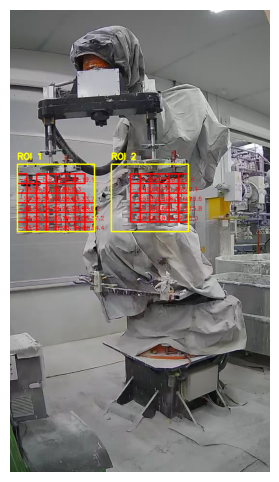

Đã lưu ảnh kết quả: raw_depth_output/result_diff_negative_cells.png


In [18]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# ================== CONFIG ==================
CELL_SIZE = 20

ROI_W = 160
ROI_H = 140

ROI_POINTS = [
    (15, 320),   # ROI 1
    (210, 320),  # ROI 2
]

IMAGE_PATHS = [
    "/content/20251211_024107_433_front_CAM1.jpg",   # ảnh 1
    "/content/20251211_024107_433_result_CAM1.jpg",  # ảnh 2
]

os.makedirs("raw_depth_output", exist_ok=True)

# ================== GRID DEPTH ==================
def compute_grid_depth(depth_map, roi_x, roi_y, roi_w, roi_h, cell_size):
    rows = roi_h // cell_size
    cols = roi_w // cell_size
    grid = np.zeros((rows, cols), dtype=np.float32)

    for r in range(rows):
        for c in range(cols):
            y0 = roi_y + r * cell_size
            x0 = roi_x + c * cell_size
            cell = depth_map[y0:y0+cell_size, x0:x0+cell_size]
            grid[r, c] = np.mean(cell)

    return grid

# ================== DRAW NEGATIVE DIFF CELLS ==================
def draw_negative_diff_cells(img, roi_x, roi_y, diff_grid, cell_size):
    img_draw = img.copy()
    rows, cols = diff_grid.shape

    for r in range(rows):
        for c in range(cols):
            diff_val = diff_grid[r, c]

            # diff < 0
            if diff_val < 0:
                x = roi_x + c * cell_size
                y = roi_y + r * cell_size

                # vẽ ô đỏ
                cv2.rectangle(
                    img_draw,
                    (x, y),
                    (x + cell_size, y + cell_size),
                    (255, 0, 0),
                    2
                )

                # ghi giá trị diff
                cv2.putText(
                    img_draw,
                    f"{diff_val:.1f}",
                    (x + 2, y + cell_size - 4),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.4,
                    (255, 0, 0),
                    1
                )

    return img_draw

# ================== MAIN PIPELINE ==================
rgb_images = []
grids_all = []

for image_path in IMAGE_PATHS:
    print(f"\nProcessing: {image_path}")

    name = os.path.splitext(os.path.basename(image_path))[0]
    depth_path = f"raw_depth_output/{name}_depth.png"

    bgr = cv2.imread(image_path)
    if bgr is None:
        raise RuntimeError(f"Không đọc được ảnh: {image_path}")

    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    rgb_images.append(rgb)

    raw_depth, _ = predict_depth(image_path, depth_path)

    image_grids = []

    for idx, (rx, ry) in enumerate(ROI_POINTS, start=1):
        grid = compute_grid_depth(
            raw_depth,
            rx, ry,
            ROI_W, ROI_H,
            CELL_SIZE
        )
        image_grids.append(grid)

        print(f"\n📐 {name} – ROI {idx} – Grid depth:")
        print(grid)

    grids_all.append(image_grids)

# ================== DIFF & DRAW ON IMAGE 1 ==================
result_img = rgb_images[0].copy()

for roi_idx, (rx, ry) in enumerate(ROI_POINTS):

    # ĐÚNG THEO YÊU CẦU:
    # diff = ảnh 1 - ảnh 2
    grid_img1 = grids_all[0][roi_idx]
    grid_img2 = grids_all[1][roi_idx]

    diff_grid = grid_img1 - grid_img2

    print(f"\nROI {roi_idx+1} – (Ảnh1 - Ảnh2):")
    print(diff_grid)

    result_img = draw_negative_diff_cells(
        result_img,
        rx, ry,
        diff_grid,
        CELL_SIZE
    )

    # vẽ khung ROI
    cv2.rectangle(
        result_img,
        (rx, ry),
        (rx + ROI_W, ry + ROI_H),
        (255, 255, 0),
        2
    )
    cv2.putText(
        result_img,
        f"ROI {roi_idx+1}",
        (rx, ry - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (255, 255, 0),
        2
    )

# ================== SHOW RESULT ==================
plt.figure(figsize=(10, 6))
plt.imshow(result_img)
plt.axis("off")
plt.show()
# ================== SAVE RESULT IMAGE ==================
result_bgr = cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR)

result_path = "raw_depth_output/result_diff_negative_cells.png"
cv2.imwrite(result_path, result_bgr)

print(f"Đã lưu ảnh kết quả: {result_path}")

